In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import tqdm
import sys
import os
import joblib
import polars as pl

In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics

In [4]:
aut_chrom_names = [f"chr{i}" for i in list(range(1, 23))]
chrom_names = aut_chrom_names + ["chrX", "chrY"]

# Read Trimming

## Prep

In [36]:
# Samples to do
sample_ids = [
    "PD50477f",
    # "PD50508bf", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD50519d",
    # "PD47269d", -- don't use, not there
    "PD50508f",
    # "PD50511e", -- don't use, likely mixture
    "PD50523b",
    # "PD48473b", -- don't use, not there
    "PD50521b",
    "PD50508b",
    # "PD50521be", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD46180c",
    # "PD50502f", -- don't use, likely mixture
    "PD50521e",
    # "PD50511e_SS",  --- don't use
    "PD50489e",
]

refinement_filenames = [
    Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
        / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.read_refinement.parquet"
    for focal_sample_id in sample_ids
    for chrom in aut_chrom_names
]

refinement_filenames = refinement_filenames[::5]

snp_filenames = [
    Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
        / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.snps.parquet"
    for focal_sample_id in sample_ids
    for chrom in aut_chrom_names
]

snp_filenames = snp_filenames


# all_events_df = pl.concat([
#     pl.scan_parquet(filename) for filename in filenames
# ])

## Sequencing single bp errors

In [6]:
%%time
toround = 10
noise_per_start_df = (
        pl.concat([
        (pl.scan_parquet(filename)
            .filter(pl.col("read_length1") >= 5000)
            .filter((pl.col("op1") == 8) & (pl.col("op2") == 8) & (pl.col("length") == 1))
            .with_columns(
                rounded_start=pl.col("start")//toround*toround,
            )
            .group_by("rounded_start")
            .len()
            .sort(by="rounded_start")
        ).collect() for filename in tqdm.tqdm(refinement_filenames)
    ])
    .group_by("rounded_start")
    .sum()
    .sort(by="rounded_start")
)

noise_per_end_df = (
        pl.concat([
        (pl.scan_parquet(filename)
            .filter(pl.col("read_length1") >= 5000)
            .filter((pl.col("op1") == 8) & (pl.col("op2") == 8) & (pl.col("length") == 1))
            .with_columns(
                rounded_end=(pl.col("read_length1")-pl.col("end"))//toround*toround,
            )
            .group_by("rounded_end")
            .len()
            .sort(by="rounded_end")
        ).collect() for filename in tqdm.tqdm(refinement_filenames)
    ])
    .group_by("rounded_end")
    .sum()
    .sort(by="rounded_end")
)

100%|██████████| 40/40 [01:30<00:00,  2.27s/it]

CPU times: user 1min 46s, sys: 16.9 s, total: 2min 3s
Wall time: 3min 21s


In [37]:
%%time
toround = 10
snp_per_start_df = (
        pl.concat([
        (pl.scan_parquet(filename)
            .filter(pl.col("read_length1") >= 5000)
            .filter((pl.col("op1") == 8) & (pl.col("op2") == 8) & (pl.col("length") == 1))
            .with_columns(
                rounded_start=pl.col("start")//toround*toround,
            )
            .group_by("rounded_start")
            .len()
            .sort(by="rounded_start")
        ).collect() for filename in tqdm.tqdm(snp_filenames)
    ])
    .group_by("rounded_start")
    .sum()
    .sort(by="rounded_start")
)

snp_per_end_df = (
        pl.concat([
        (pl.scan_parquet(filename)
            .filter(pl.col("read_length1") >= 5000)
            .filter((pl.col("op1") == 8) & (pl.col("op2") == 8) & (pl.col("length") == 1))
            .with_columns(
                rounded_end=(pl.col("read_length1")-pl.col("end"))//toround*toround,
            )
            .group_by("rounded_end")
            .len()
            .sort(by="rounded_end")
        ).collect() for filename in tqdm.tqdm(snp_filenames)
    ])
    .group_by("rounded_end")
    .sum()
    .sort(by="rounded_end")
)

100%|██████████| 198/198 [00:17<00:00, 11.34it/s]

CPU times: user 50.4 s, sys: 7.39 s, total: 57.8 s
Wall time: 41.3 s


## Insertions

In [7]:
%%time
toround = 10
insertion_per_start_df = (
        pl.concat([
        (pl.scan_parquet(filename)
            .filter(pl.col("read_length1") >= 5000)
            .filter((pl.col("op1") == 1) & (pl.col("op2") == 1) & (pl.col("length") <= 5))
            .with_columns(
                rounded_start=pl.col("start")//toround*toround,
            )
            .group_by("rounded_start")
            .len()
            .sort(by="rounded_start")
        ).collect() for filename in tqdm.tqdm(refinement_filenames)
    ])
    .group_by("rounded_start")
    .sum()
    .sort(by="rounded_start")
)

insertion_per_end_df = (
        pl.concat([
        (pl.scan_parquet(filename)
            .filter(pl.col("read_length1") >= 5000)
            .filter((pl.col("op1") == 1) & (pl.col("op2") == 1) & (pl.col("length") <= 5))
            .with_columns(
                rounded_end=(pl.col("read_length1")-pl.col("end"))//toround*toround,
            )
            .group_by("rounded_end")
            .len()
            .sort(by="rounded_end")
        ).collect() for filename in tqdm.tqdm(refinement_filenames)
    ])
    .group_by("rounded_end")
    .sum()
    .sort(by="rounded_end")
)

100%|██████████| 40/40 [00:58<00:00,  1.46s/it]

CPU times: user 2min 3s, sys: 19.5 s, total: 2min 23s
Wall time: 1min 18s


In [8]:
%%time
toround = 10
deletion_per_start_df = (
    pl.concat([
        (pl.scan_parquet(filename)
            .filter(pl.col("read_length1") >= 5000)
            .filter((pl.col("op1") == 2) & (pl.col("op2") == 2) & (pl.col("length") <= 5))
            .with_columns(
                rounded_start=pl.col("start")//toround*toround,
            )
            .group_by("rounded_start")
            .len()
            .sort(by="rounded_start")
        ).collect() for filename in tqdm.tqdm(refinement_filenames)
    ])
    .group_by("rounded_start")
    .sum()
    .sort(by="rounded_start")
)


deletion_per_end_df = (
        pl.concat([
        (pl.scan_parquet(filename)
            .filter(pl.col("read_length1") >= 5000)
            .filter((pl.col("op1") == 2) & (pl.col("op2") == 2) & (pl.col("length") <= 5))
            .with_columns(
                rounded_end=(pl.col("read_length1")-pl.col("end"))//toround*toround,
            )
            .group_by("rounded_end")
            .len()
            .sort(by="rounded_end")
        ).collect() for filename in tqdm.tqdm(refinement_filenames)
    ])
    .group_by("rounded_end")
    .sum()
    .sort(by="rounded_end")
)

100%|██████████| 40/40 [00:23<00:00,  1.67it/s]

CPU times: user 2min 5s, sys: 18.7 s, total: 2min 23s
Wall time: 59.7 s


## Read lengths, to get the numerator

In [9]:
%%time
read_lengths = \
    np.sort(np.concatenate([
        (pl.scan_parquet(filename)
            .select("read_name", "read_length1")
            .unique("read_name")
            .collect(streaming=True)
            ["read_length1"].to_numpy()
        ) for filename in tqdm.tqdm(refinement_filenames)
    ]))

100%|██████████| 40/40 [01:48<00:00,  2.71s/it]

CPU times: user 3min 1s, sys: 15.7 s, total: 3min 17s
Wall time: 1min 48s


In [14]:
read_coverages_x = np.arange(0, 20000, toround)
read_coverages_y = (len(read_lengths) - np.searchsorted(read_lengths, read_coverages_x))*toround

In [38]:
noise_df = (noise_per_start_df
    .rename({"len": "start_count"})
    .join(
        noise_per_end_df.rename({"len": "end_count", "rounded_end": "rounded_start"}),
        on="rounded_start",
    )
    .join(
        pl.DataFrame({"rounded_start": read_coverages_x, "cov": read_coverages_y}), 
        on="rounded_start",
    )
    .with_columns(ratio=(pl.col("start_count") + pl.col("end_count"))/(2*pl.col("cov")))
)

snp_df = (snp_per_start_df
    .rename({"len": "start_count"})
    .join(
        snp_per_end_df.rename({"len": "end_count", "rounded_end": "rounded_start"}),
        on="rounded_start",
    )
    .join(
        pl.DataFrame({"rounded_start": read_coverages_x, "cov": read_coverages_y}), 
        on="rounded_start",
    )
    .with_columns(ratio=(pl.col("start_count") + pl.col("end_count"))/(2*pl.col("cov")))
)


insertion_df = (insertion_per_start_df
    .rename({"len": "start_count"})
    .join(
        insertion_per_end_df.rename({"len": "end_count", "rounded_end": "rounded_start"}),
        on="rounded_start",
    )
    .join(
        pl.DataFrame({"rounded_start": read_coverages_x, "cov": read_coverages_y}), 
        on="rounded_start",
    )
    .with_columns(ratio=(pl.col("start_count") + pl.col("end_count"))/(2*pl.col("cov")))
)

deletion_df = (deletion_per_start_df
    .rename({"len": "start_count"})
    .join(
        deletion_per_end_df.rename({"len": "end_count", "rounded_end": "rounded_start"}),
        on="rounded_start",
    )
    .join(
        pl.DataFrame({"rounded_start": read_coverages_x, "cov": read_coverages_y}), 
        on="rounded_start",
    )
    .with_columns(ratio=(pl.col("start_count") + pl.col("end_count"))/(2*pl.col("cov")))
)




## Plot

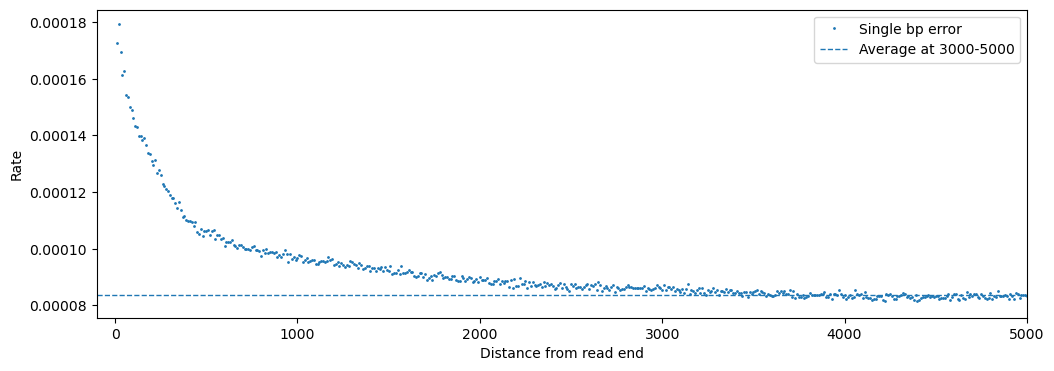

In [30]:
plt.figure(figsize=(12,4));
plt.plot(
    noise_df["rounded_start"][1:1000],
    noise_df["ratio"][1:1000],
    '.',
    ms=2,
    lw=0.5,
    label="Single bp error",
    color="C0",
);
plt.axhline(noise_df["ratio"][300:500].mean(), color="C0", lw=1, ls="--", label="Average at 3000-5000")

plt.xlim(-100,5000);
plt.legend();
plt.ylabel("Rate");
plt.xlabel("Distance from read end");

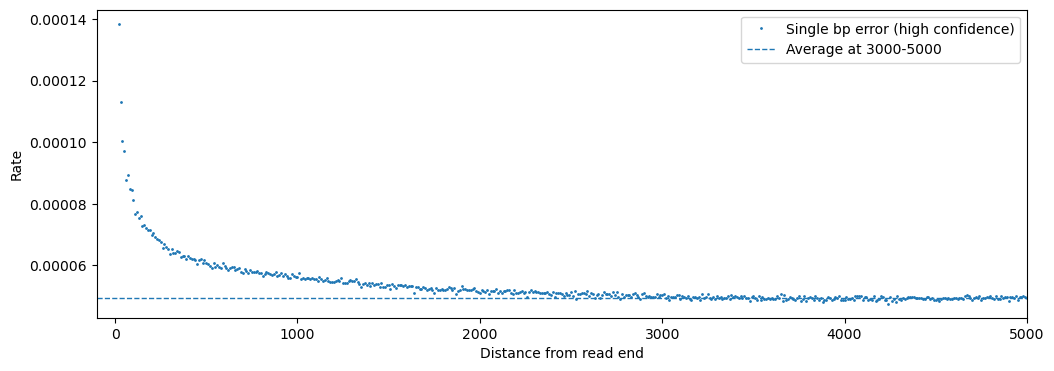

In [39]:
plt.figure(figsize=(12,4));
plt.plot(
    snp_df["rounded_start"][1:1000],
    snp_df["ratio"][1:1000],
    '.',
    ms=2,
    lw=0.5,
    label="Single bp error (high confidence)",
    color="C0",
);
plt.axhline(snp_df["ratio"][300:500].mean(), color="C0", lw=1, ls="--", label="Average at 3000-5000")

plt.xlim(-100,5000);
plt.legend();
plt.ylabel("Rate");
plt.xlabel("Distance from read end");

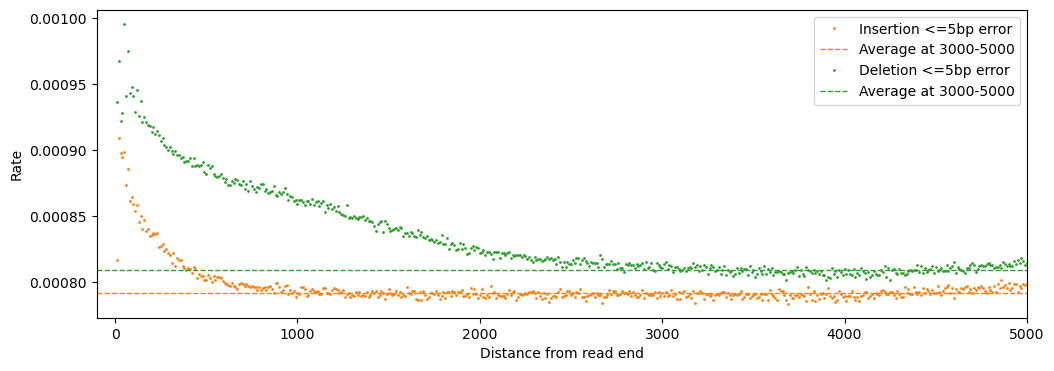

In [29]:
plt.figure(figsize=(12,4));


plt.plot(
    insertion_df["rounded_start"][1:1000],
    insertion_df["ratio"][1:1000],
    '.',
    ms=2,
    lw=0.5,
    label="Insertion <=5bp error",
    color="C1",
);
plt.axhline(insertion_df["ratio"][300:500].mean(), color="C1", lw=1, ls="--", label="Average at 3000-5000")


plt.plot(
    deletion_df["rounded_start"][1:1000],
    deletion_df["ratio"][1:1000],
    '.',
    ms=2,
    lw=0.5,
    label="Deletion <=5bp error",
    color="C2",
);
plt.axhline(deletion_df["ratio"][300:500].mean(), color="C2", lw=1, ls="--", label="Average at 3000-5000")


plt.xlim(-100,5000);
plt.legend();
plt.ylabel("Rate");
plt.xlabel("Distance from read end");